# Stochastic Optimization

## 3.1 Genetic Algorithms

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson | <a href="https://supaerodatascience.github.io/stochastic/">https://supaerodatascience.github.io/stochastic/</a>

While evolutionary strategies are well adapted for continuous optimization, they are less useful for discrete or combinatorial optimization. In ES, population generation follows distributions which can create individuals that don't respect problem constraints; in CMA-ES, for example, constraints are usually handled by introducing a fitness penalty.

Today we'll look at an algorithm that can be adapted to meet problem constraints and which is often used in binary or discrete optimization: the Genetic Algorithm. This algorithm uses random selection and genetic recombination in a large population of individuals. It has a flexible definition which allows for adaptation to different problems, but the basic components remain the same.

<img src="imgs/ga.png">

Today we'll see an application of the Genetic Algorithm to the Travelling Salesman Problem. In the next section, we'll extend the Genetic Algorithm to the multi-objective case with the NSGA-II algorithm.

## Population

The first decision when using a Genetic Algorithm is the choice of solution representation. To create the first population, we create random solutions (individuals) in this representation (genome), and we'll later modify individuals by combining and mutating the genome. The genome representation depends on the problem, which for this example is the TSP. As a reminder, the Travelling Salesman Problem requires visiting every city in a list of cities *exactly once*. The goal is to minimize the total distance traveled. We'll randomly generate some cities and use their Euclidean distance.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
n_cities = 10
cities = np.random.rand(n_cities, 2)
rng = np.random.default_rng()

To represent a solution, we can use the order of cities traveled. Each solution must have each city *exactly once*, ie a permutation of the indices of the list of cities. This is a concise way to represent the path traveled which is also easy to mutate, as we'll see later.

In [3]:
order0 = rng.permutation(n_cities)
order1 = rng.permutation(n_cities)
print(order0)
print(order1)

[0 1 5 4 2 3 9 8 7 6]
[1 9 7 5 6 8 3 2 0 4]


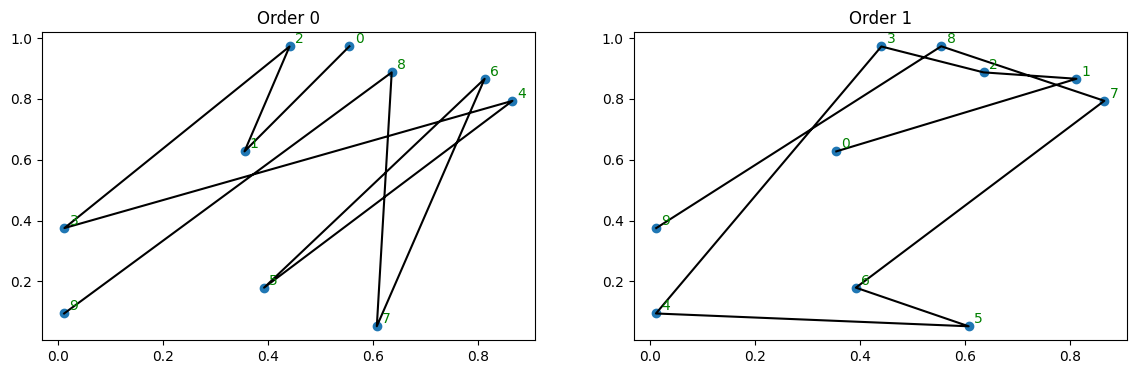

In [4]:
fig = plt.figure(figsize=(14, 4))
ax = plt.subplot(1, 2, 1)
ind = order0
plt.title("Order 0")
ax.scatter(cities[ind, 0], cities[ind, 1])
ax.plot(cities[ind, 0], cities[ind, 1], 'k')
for i in range(n_cities):
    ax.annotate(i, (cities[ind[i], 0]+0.01, cities[ind[i], 1]+0.01), c='g')
ax = plt.subplot(1, 2, 2)
ind = order1
plt.title("Order 1")
ax.scatter(cities[ind, 0], cities[ind, 1])
ax.plot(cities[ind, 0], cities[ind, 1], 'k')
for i in range(n_cities):
    ax.annotate(i, (cities[ind[i], 0]+0.01, cities[ind[i], 1]+0.01), c='g')

For our initial GA population, we will create 100 random permutations. Note that there are $10!$ possible solutions to the (asymmetric) TSP with 10 cities, so 100 is very small compared to the total size. However, it is much larger than the population sizes used by CMA-ES or others. This is one distinguishing feature of Genetic Algorithms: they tend to use larger population sizes.

In [5]:
n_population = 100
population = np.array([rng.permutation(n_cities) for i in range(n_population)])
population[:5]

array([[1, 6, 5, 7, 3, 8, 2, 0, 4, 9],
       [2, 0, 5, 6, 7, 3, 1, 4, 9, 8],
       [8, 9, 6, 7, 3, 5, 1, 4, 2, 0],
       [6, 0, 2, 5, 9, 3, 7, 8, 1, 4],
       [9, 5, 2, 0, 1, 6, 8, 4, 7, 3]])

## Evaluation

The evaluation step of a Genetic Algorithm is the same as in other stochastic algorithms: each solution must be evaluated by the objective function. In this case, that's the total distance traveled when using the solution order.

In [6]:
d = np.zeros((n_cities, n_cities))
for i in range(n_cities):
    for j in range(i):
        d[i, j] = np.sqrt((cities[i, 0] - cities[j, 0])**2 + (cities[i,1] - cities[j, 1])**2)
        d[j, i] = d[i, j]
d[:3, :3]

array([[0.        , 0.39901429, 0.35834819],
       [0.39901429, 0.        , 0.53632436],
       [0.35834819, 0.53632436, 0.        ]])

In [7]:
def total_distance(order, distances):
    t = 0
    for i in range(1, len(order)):
        t += distances[order[i-1], order[i]]
    return t

In [8]:
print("order 0:", total_distance(order0, d))
print("order 1:", total_distance(order1, d))

order 0: 6.700287136992609
order 1: 4.668422809553482


In [9]:
def evaluate(population, distances):
    fitness = np.zeros(len(population))
    for i in range(len(population)):
        fitness[i] = total_distance(population[i], distances)
    return fitness

In [10]:
fitness = evaluate(population, d)
for i in range(3):
    print(population[i], fitness[i])
print("Minimum: ")
print(population[np.argmin(fitness)], np.min(fitness), np.max(fitness))

[1 6 5 7 3 8 2 0 4 9] 5.708098008521644
[2 0 5 6 7 3 1 4 9 8] 5.857215867842378
[8 9 6 7 3 5 1 4 2 0] 6.589467154474598
Minimum: 
[3 6 4 8 2 0 1 7 5 9] 3.8692044818664613 6.952468538220987


## <a id="selection"></a>Selection

Which individuals should pass on their genetic information to the next generation? We could imagine a simple schemes of taking the best individuals globally, say 20% of them. This is known as truncation selection. In simple problems with no local minima, such a method might work. However, we would lose important genetic diversity, one of the main advantages of the large population in a Genetic Algorithm.

In [11]:
def truncation_selection(population, fitness, p=0.2):
    n_elites = int(np.floor(len(population) * p))
    elites = np.argsort(fitness)[:n_elites]
    return population[elites], fitness[elites]

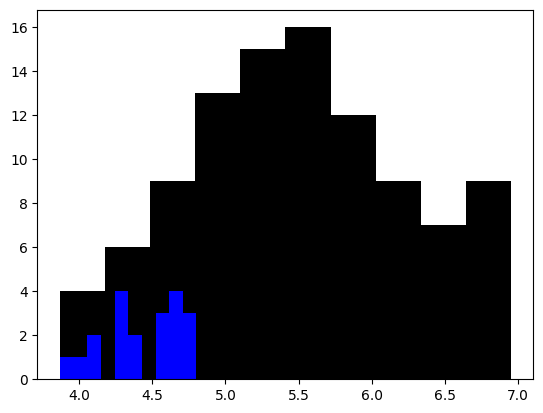

In [12]:
elites, efit = truncation_selection(population, fitness)
plt.hist(fitness, color='k')
plt.hist(efit, color='b');

To preserve genetic diversity, we'll instead allow any member of the population to have a chance of being selected, based on their fitness. One method would be to draw from the population randomly using a probability based on the fitness of each individual. This is known as fitness proportionate selection. 

In [13]:
def fp_selection(population, fitness):
    p = (np.max(fitness) - fitness)
    p /= np.sum(p)
    rng = np.random.default_rng()
    ind = rng.choice(len(population), p=p)
    return population[ind], fitness[ind]

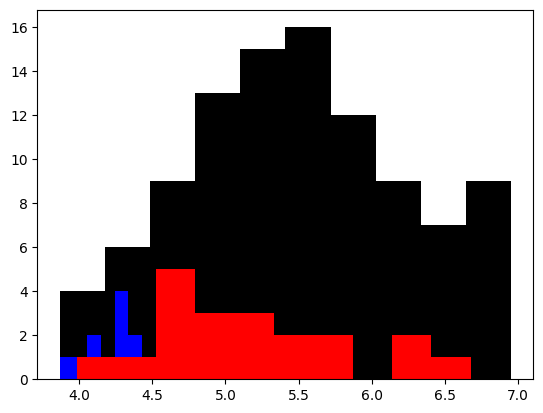

In [14]:
fp_fits = np.zeros(len(efit))
for i in range(len(efit)):
    p, f = fp_selection(population, fitness)
    fp_fits[i] = f
plt.hist(fitness, color='k')
plt.hist(efit, color='b')
plt.hist(fp_fits, color='r');

One of the desirable properties of CMA-ES was invariance to certain transformations in the search space. Because CMA-ES is based on the **order** of fitness values instead of their value, any transformation of the search space which maintains population order does not affect the search. This makes the search more generalizable to different search spaces.

Hansen, Nikolaus, et al. "Impacts of invariance in search: When CMA-ES and PSO face ill-conditioned and non-separable problems." Applied Soft Computing 11.8 (2011): 5755-5769. [pdf]

In a genetic algorithm, we can acheive the same invariance by using a random ordering of individuals. To do so, we randomly select a subset of individuals, called a tournament, and then take the best individual from that random subset. This is known as tournament selection. Because tournament selection doesn't depend on the absolute fitness value but rather the ranking of individuals in a tournament, it is also invariant to order-preserving transformations.

<div class="alert alert-success">
    <h3>Exercise 1</h3>

Complete the following tournament selection definition which uses a tournament size of `t_size=3`. Plot the selected individuals and compare it to truncation selection and fitness proportionate selection.
</div>

In [15]:
def tournament_selection(population, fitness, t_size=3):
    ind = rng.choice(len(population))
    return population[ind], fitness[ind]

In [16]:
# %load solutions/3_1_1.py

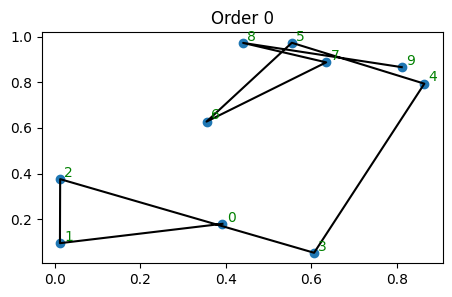

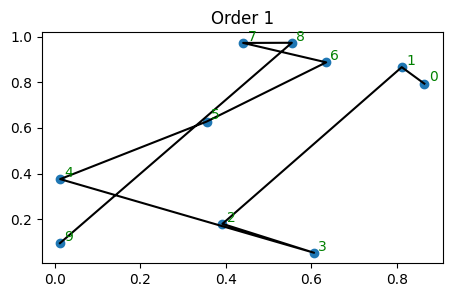

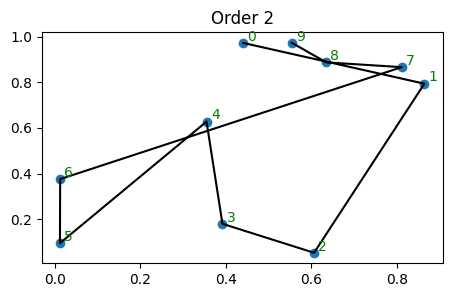

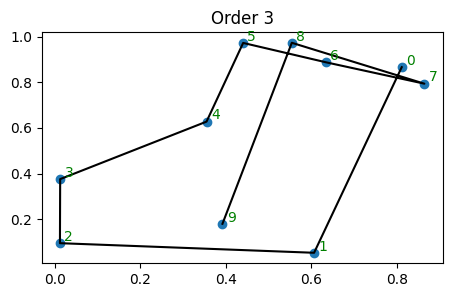

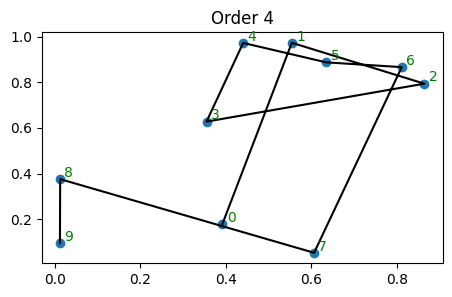

In [17]:
indivs = elites[:5]
#indivs = []
#for i in range(5):
#    p, f = tournament_selection(population, fitness)
#    indivs.append(p)
for i in range(len(indivs)):
    fig = plt.figure(figsize=(6*len(indivs), 3))
    ax = plt.subplot(1, len(indivs), 1)
    ind = indivs[i]
    plt.title("Order "+str(i))
    ax.scatter(cities[ind, 0], cities[ind, 1])
    ax.plot(cities[ind, 0], cities[ind, 1], 'k')
    for i in range(n_cities):
        ax.annotate(i, (cities[ind[i], 0]+0.01, cities[ind[i], 1]+0.01), c='g')

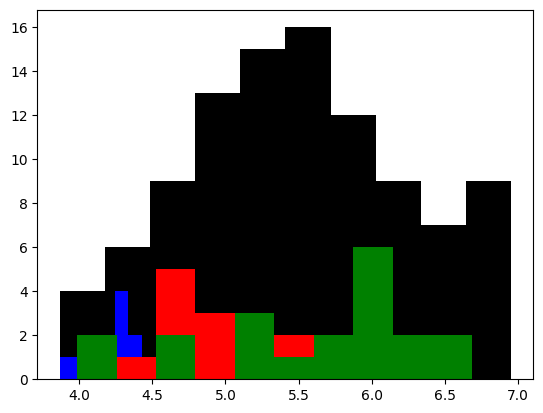

In [18]:
t_fits = np.zeros(len(efit))
for i in range(len(efit)):
    p, f = tournament_selection(population, fitness)
    t_fits[i] = f
plt.hist(fitness, color='k')
plt.hist(efit, color='b')
plt.hist(fp_fits, color='r')
plt.hist(t_fits, color='g');

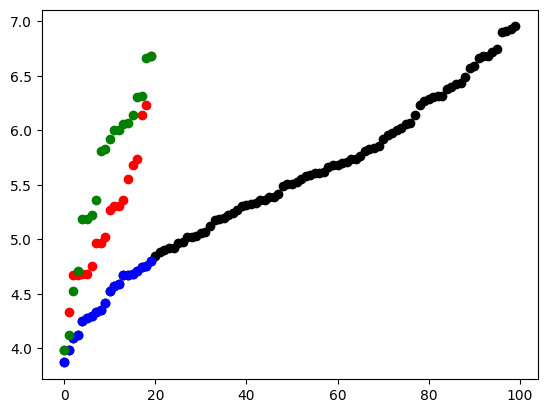

In [19]:
plt.scatter(range(len(fitness)), np.sort(fitness), color='k')
plt.scatter(range(len(efit)), np.sort(efit), color='b')
plt.scatter(range(len(fp_fits)), np.sort(fp_fits), color='r')
plt.scatter(range(len(t_fits)), np.sort(t_fits), color='g');

## <a id="crossover"></a>Crossover

Considering we have such a large population, is there some way to combine individual solutions to lead to better solutions? For example, could we make an individual which inherits information from two parent individuals? This is the idea behind crossover, the other operator in genetic algorithms besides mutation. It is based on sexual reproduction where the genetic information of two parent individuals is mixed to create an offspring individual. The idea of combining the information from multiple individuals together to create the next generation is something we'll explore in more detail next class when discussing evolutionary strategies. For now, let's look at ways to combine two individuals.

<img src="imgs/crossover.png" width="80%" height="auto">

In [20]:
def one_point(p1, p2):
    rng = np.random.default_rng()
    x = rng.choice(np.arange(1, np.minimum(len(p1)-1, len(p2)-1)))
    return np.concatenate((p1[:x], p2[x:])), np.concatenate((p2[:x],p1[x:]))

In [21]:
parent1, _ = tournament_selection(population, fitness)
parent2, _ = tournament_selection(population, fitness)
print(parent1, parent2)
child1, child2 = one_point(parent1, parent2)
print("crossover: ")
print(child1, child2)

[7 3 6 0 8 1 5 4 9 2] [4 6 7 1 2 0 8 5 9 3]
crossover: 
[7 3 7 1 2 0 8 5 9 3] [4 6 6 0 8 1 5 4 9 2]


The one point crossover method is a common one, inspired by biology and useful for combining solutions in a number of problems. When increasing the number of swapping points beyond 1, this is known as k-point crossover, and it is useful when the problem dimensions are independent.

In the Travelling Salesman problem, however, the dimensions of the problem are not independent; there is the constraint that all cities must be visited and also that no city can be visted twice. Instead, we'll use a crossover operator which respects those constraints. This is known as the edge recombination operator and it can be applied to any directed graph recombination problem.

<img src="https://upload.wikimedia.org/wikipedia/commons/e/e5/Genetic_ero_crossover.svg" alt="Genetic ero crossover.svg" width="50%" height="auto">

https://en.wikipedia.org/wiki/Edge_recombination_operator
    
Whitley, L. Darrell, Timothy Starkweather, and D'Ann Fuquay. "Scheduling problems and traveling salesmen: The genetic edge recombination operator." ICGA. Vol. 89. 1989. [pdf](TSP_crossover.pdf)

This operator randomly selects from the neighborhood of each node. This operator is rather long to code, so we'll use the [definition](https://github.com/anyoptimization/pymoo/blob/master/pymoo/operators/crossover/erx.py) from the [pymoo](https://pymoo.org/index.html) library. We'll use `pymoo` in the next notebook, so install it now if you haven't yet.

In [22]:
from pymoo.operators.crossover import erx

print("Parents")
print(population[0], population[1])
print("Adjacency Matrix 1")
print(erx.calc_adjency_matrix(population[0]))
print("Adjacency Matrix 2")
print(erx.calc_adjency_matrix(population[1]))
print("Child")
erx.erx(population[0], population[1])

Parents
[1 6 5 7 3 8 2 0 4 9] [2 0 5 6 7 3 1 4 9 8]
Adjacency Matrix 1
{1: {9, 6}, 6: {1, 5}, 5: {6, 7}, 7: {3, 5}, 3: {8, 7}, 8: {2, 3}, 2: {8, 0}, 0: {2, 4}, 4: {0, 9}, 9: {1, 4}}
Adjacency Matrix 2
{2: {8, 0}, 0: {2, 5}, 5: {0, 6}, 6: {5, 7}, 7: {3, 6}, 3: {1, 7}, 1: {3, 4}, 4: {1, 9}, 9: {8, 4}, 8: {9, 2}}
Child


[5, 7, 6, 1, 3, 8, 2, 0, 4, 9]

## <a id="mutation"></a>Mutation

Crossover combines genetic information already existing in the population. In order to search outside the possible combinations of the population, we need to directly modify individuals. This is done using mutation, which is applied either directly to individuals from selection or, more commonly, from the new individuals created by crossover. In general, mutation operators should not greatly modify an individual, changing only a small percentage of genes. An example is uniform mutation, which randomly resamples some genes. A common mutation rate for this is `1/n_genes`, meaning that, on average, only one gene is changed.

As with crossover, we need to create a mutation operator which respects the constraints of the Travelling Salesman Problem. One such mutation operator would be to switch the order of a single random pair of cities, the same "neighbor" generating operator we discussed for Simulated Annealing.

<div class="alert alert-success">
    <h3>Exercise 2</h3>

Complete the following mutation operator definition which inverts a single random pair of cities.
</div>

In [23]:
def mutate(ind):
    return ind

In [ ]:
# %load solutions/3_1_2.py
def mutate(ind):
    rng = np.random.default_rng()
    x = rng.choice(len(ind)-1)
    child = np.copy(ind)
    child[x] = ind[x+1]
    child[x+1] = ind[x]
    return child


In [32]:
# Mutation en swapant x et x+1 induit moins de variation que de swap x et y. Ici c'est ce qu'on cherche

In [25]:
print(population[0], population[1])
child = erx.erx(population[0], population[1])
print(child)
mutate(child)

[1 6 5 7 3 8 2 0 4 9] [2 0 5 6 7 3 1 4 9 8]
[5, 7, 6, 1, 3, 8, 9, 4, 0, 2]


[5, 7, 6, 1, 3, 8, 9, 4, 0, 2]

## <a id="ga"></a>The Genetic Algorithm

Now that we have all the different parts, we can combine them in the full genetic algorithm. We'll use two different selection methods: first, a truncation selection of the best few individuals which will pass directly to the next population. This is known as **elitism** and is done to preserve the best solutions between generations. Then, we'll use tournament selection to select parents for crossover. Finally, we'll mutate the result from crossover and pass this new individual into the next population.

In [26]:
def ga_step(population, elite_percentage = 0.2):
    fitness = evaluate(population, d)
    next_pop, _ = truncation_selection(population, fitness, p=elite_percentage)
    while len(next_pop) < len(population):
        parent1, _ = tournament_selection(population, fitness)
        parent2, _ = tournament_selection(population, fitness)
        child = erx.erx(parent1, parent2)
        child = mutate(child)
        next_pop = np.concatenate((next_pop, [child]))
    return next_pop, fitness

In [27]:
n_cities = 20
cities = np.random.rand(n_cities, 2)
d = np.zeros((n_cities, n_cities))
for i in range(n_cities):
    for j in range(i):
        d[i, j] = np.sqrt((cities[i, 0] - cities[j, 0])**2 + (cities[i,1] - cities[j, 1])**2)
        d[j, i] = d[i, j]

In [40]:
n_population = 100
n_gen = 100
elite_percentage = 0.2
def run_optim(n_population, n_gen, elite_percentage, verbose = False):
    population = np.array([rng.permutation(n_cities) for i in range(n_population)])
    minfit = np.zeros(n_gen)
    for i in range(n_gen):
        population, fitness = ga_step(population, elite_percentage)
        minfit[i] = np.min(fitness)
        if verbose:
            if i > 2 and minfit[i] < minfit[i-1]:
                print(i, minfit[i])
    return minfit

4 7.043684451565776
6 6.664579657343031
7 6.438850335296085
8 6.35120687358154
9 5.815342277470235
11 5.807257392444194
12 5.774249944316273
14 5.348501576923655
15 4.832221205865957
28 4.436055794407554
35 4.3140628497536975
44 4.314062849753697
60 4.182597087752634
62 4.111306338136464
64 4.02072866337462
96 3.9754494462376937
[7.70903556 7.70903556 7.24715192 7.24715192 7.04368445 7.04368445
 6.66457966 6.43885034 6.35120687 5.81534228 5.81534228 5.80725739
 5.77424994 5.77424994 5.34850158 4.83222121 4.83222121 4.83222121
 4.83222121 4.83222121 4.83222121 4.83222121 4.83222121 4.83222121
 4.83222121 4.83222121 4.83222121 4.83222121 4.43605579 4.43605579
 4.43605579 4.43605579 4.43605579 4.43605579 4.43605579 4.31406285
 4.31406285 4.31406285 4.31406285 4.31406285 4.31406285 4.31406285
 4.31406285 4.31406285 4.31406285 4.31406285 4.31406285 4.31406285
 4.31406285 4.31406285 4.31406285 4.31406285 4.31406285 4.31406285
 4.31406285 4.31406285 4.31406285 4.31406285 4.31406285 4.31406285

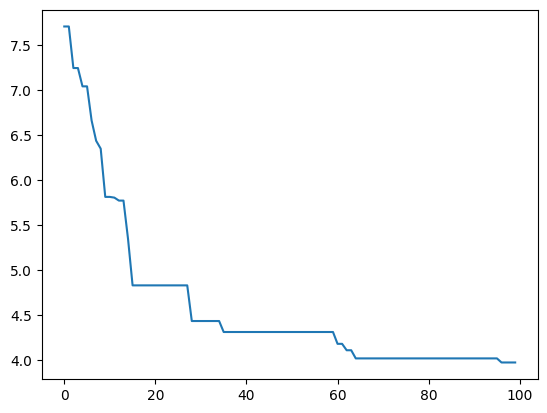

In [41]:
minfit = run_optim(n_population, n_gen, elite_percentage, verbose=True)
plt.plot(minfit);

<div class="alert alert-success">
    <h3>Exercise 3</h3>

Study two hyperparameters of the genetic algorithm: the population size and the number of elites. How do these affect the search? Are elites necessary?
</div>

<div class="alert alert-info">
    <h3>Discussion</h3>

In the Genetic Algorithm, how many evaluations were performed? Is this the same as the total number of permutations explored? Roughly, how many permutations were calculated compared to the total number of possible city permutations? Has the GA converged on the best possible solution? When should the GA stop?
</div>

pop=100, elite=10.0%
pop=100, elite=20.0%
pop=100, elite=30.0%
pop=100, elite=40.0%
pop=100, elite=50.0%
pop=100, elite=60.0%
pop=100, elite=70.0%
pop=100, elite=80.0%
pop=100, elite=90.0%


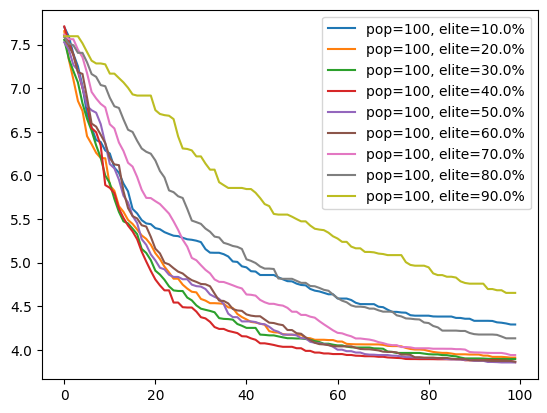

In [45]:
n_population = [100]
n_gen = 100
elite_percentage = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for x in n_population:
    for y in elite_percentage:
        print("pop="+str(x)+", elite="+str(y*100)+"%")
        minfit_list = []
        for _ in range(10):
            minfit_list.append(run_optim(x, n_gen, y))
        plt.plot(np.mean(minfit_list, axis=0), label="pop="+str(x)+", elite="+str(y*100)+"%");
plt.legend()
plt.show()